<a href="https://colab.research.google.com/github/shanikairoshi/Communication-Efficient-DUQFL/blob/main/main_v2_0.1initials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# %%capture
!pip install genomic-benchmarks
!pip install qiskit qiskit_machine_learning qiskit_algorithms qiskit-aer




In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import sys
from pathlib import Path
PROJ = Path.cwd() / "tduqfl_Project_AGG"
if str(PROJ) not in sys.path:
    sys.path.insert(0, str(PROJ))
import sys
sys.path.append('/content/drive/MyDrive/Teleportation/tduqfl_Project_AGG/tDuQFL_Project')
# ─── 5. Assemble filenames for each artifact ─────────────────────────────────
#drive_root = "/content/drive/MyDrive/Teleportation/tduqfl_Project_AGG/tDuQFL_Project/"

In [4]:
from common.imports import *
from configs.dataset_genome_iid import *     # swap to other configs as needed
from io_utils.naming import stamp_now, flags, build_param_str, make_filenames

start_str, date_str = stamp_now()
teleport_pl, noise_pl = flags(use_teleportation, use_noise)
param_str = build_param_str(num_clients, num_federated_layers, num_deep_unfolding_iterations,
                            initial_learning_rate, initial_perturbation)

best_client_csv_file, global_csv_file, local_csv_file, validation_csv_file = make_filenames(
    drive_root, dataset_name, split_type, date_str, teleport_pl, noise_pl, param_str
)
from io_utils.csv_logger import init_local_csv, init_best_csv, init_validation_csv

# Create folders + write headers
init_best_csv(best_client_csv_file)

local_headers = [
    "Federated Round", "Client Number", "Iteration",
    "Objective Function Value", "Training Accuracy", "Test Accuracy",
    "Learning Rate", "Perturbation"
]
init_local_csv(local_csv_file, local_headers)

init_validation_csv(validation_csv_file)

# Do NOT pre-init global_csv_file here because your save_accuracies_to_csv()
# already writes the header each time it runs (in 'w' mode).

/usr/local/lib/python3.12/dist-packages/genomic_benchmarks/utils/datasets.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Python: 3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]
Qiskit: 1.4.4
qiskit_aer available?: True


Load and Split data

In [5]:
from data.preprocess_genome import load_and_prepare_dataset
from data.splitters import split_dataset_for_epochs
from configs.base_config import (
    num_clients, num_epochs, samples_per_epoch, split_type,
    global_seed
)

np_train_data, np_test_data = load_and_prepare_dataset(word_size, global_seed)

# 2) Compute feasible epoch capacity and cap both epochs and rounds
N_train = len(np_train_data)
train_capacity = N_train // (num_clients * samples_per_epoch)
num_epochs_eff = max(1, min(num_epochs, train_capacity))

if train_capacity == 0:
    raise ValueError(
        f"Not enough training samples ({N_train}) for "
        f"{num_clients=} × {samples_per_epoch=} per epoch. "
        "Reduce samples_per_epoch or num_clients, or enable resampling."
    )

num_federated_layers_eff = min(num_federated_layers, num_epochs_eff)

# Build clients
if split_type.lower() == "iid":
    from data.splitters import split_dataset_for_epochs
    clients = split_dataset_for_epochs(
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        train_data=np_train_data,
        test_data=np_test_data,
        samples_per_epoch=samples_per_epoch,
    )
elif split_type.lower() in {"noniid", "non-iid", "non_iid"}:
    from data.noniid import make_non_iid_clients
    clients = make_non_iid_clients(
        train_data=np_train_data,
        test_data=np_test_data,
        num_clients=num_clients,
        num_epochs=num_epochs_eff,             # or num_epochs
        samples_per_epoch=samples_per_epoch,
        non_iid_ratio=0.8,                     # tune as needed
        quantity_variation=0.5,                # tune as needed
        seed=global_seed,
        plot=True
    )
else:
    raise ValueError(f"Unknown split_type: {split_type}")

'''
clients = split_dataset_for_epochs(
    num_clients=num_clients, num_epochs=num_epochs,
    train_data=np_train_data, test_data=np_test_data,
    samples_per_epoch=samples_per_epoch
)
'''
# validation/tables
test_sequences = np.array([d["sequence"] for d in np_test_data])
test_labels    = np.array([d["label"]    for d in np_test_data])
X_val, y_val   = test_sequences, test_labels

# derive num_features once
if clients and clients[0].data and clients[0].data[0]:
    num_features = clients[0].data[0][0]['sequence'].shape[0]
else:
    raise RuntimeError("Empty client data – check splitting indices.")


In [6]:
# Infer num_features from the first available sample in clients
def infer_num_features_from_clients(clients):
    for c in clients:
        for epoch_data in c.data:              # list of samples for that epoch
            if not epoch_data:
                continue
            sample = epoch_data[0]
            if "sequence" in sample:           # your Genome pipeline
                arr = np.asarray(sample["sequence"])
                return int(arr.size)
            if "features" in sample:           # some other pipelines
                arr = np.asarray(sample["features"])
                return int(arr.size)
            if "image" in sample:              # e.g., MNIST before flatten
                arr = np.asarray(sample["image"]).reshape(-1)
                return int(arr.size)
            # add any other key you use
    raise RuntimeError("Could not infer num_features: no samples found.")

num_features = infer_num_features_from_clients(clients)
print(f"[info] num_features = {num_features}")


[info] num_features = 5


run federated loop and plot

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

[Round 0] Teleportation OFF | Aggregation=best
[round 0 | client 0] seed LR=0.1000000000 (prev=0.1000000000), seed PERT=0.1000000000 (prev=0.1000000000), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.541585 step=0.008759 g_raw=+0.004 g_sm=+0.002 acc=1 | LR→0.100200 PERT→0.100000 (scale=0.04)
[meta] cb#010 loss=0.532662 step=0.03616 g_raw=+0.018 g_sm=+0.007 acc=1 | LR→0.100401 PERT→0.100000 (scale=0.04)
[meta] cb#015 loss=0.531436 step=0.02267 g_raw=+0.011 g_sm=+0.007 acc=1 | LR→0.100602 PERT→0.100000 (scale=0.04)
[meta] cb#020 loss=0.524800 step=0.08009 g_raw=+0.043 g_sm=+0.011 acc=1 | LR→0.100804 PERT→0.100000 (scale=0.04)
[meta] cb#025 loss=0.524237 step=0.02262 g_raw=+0.012 g_sm=+0.010 acc=1 | LR→0.101006 PERT→0.100001 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1000000000, PERT_used=0.1000000000 → LR_next=0.1010056524, PERT_next=0.1000006294
[meta-summary] callbacks=25 g_raw_mean=+0.014 g_sm_mean=+0.006 acc_ratio=1.00 | LR 0.1000000000→0.1010056524 PERT 0.10000000

Training Progress:  10%|█         | 1/10 [09:13<1:23:02, 553.61s/it]

[Round   0] acc_g=0.717 (μ=0.690, σ=0.100, FG=0.224) | t=544.050s, val=0.556 | TEL=FALSE
[Round 1] Teleportation OFF | Aggregation=best
[round 1 | client 0] seed LR=0.1025665831 (prev=0.1051331663), seed PERT=0.1000028806 (prev=0.1000057612), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.514080 step=0.02331 g_raw=+0.012 g_sm=+0.004 acc=1 | LR→0.102772 PERT→0.100003 (scale=0.04)
[meta] cb#010 loss=0.511641 step=0.04749 g_raw=+0.024 g_sm=+0.006 acc=1 | LR→0.102978 PERT→0.100003 (scale=0.04)
[meta] cb#015 loss=0.503346 step=0.06879 g_raw=+0.036 g_sm=+0.010 acc=1 | LR→0.103184 PERT→0.100003 (scale=0.04)
[meta] cb#020 loss=0.500769 step=0.006365 g_raw=+0.003 g_sm=+0.011 acc=1 | LR→0.103391 PERT→0.100003 (scale=0.04)
[meta] cb#025 loss=0.499031 step=0.02066 g_raw=+0.010 g_sm=+0.011 acc=1 | LR→0.103598 PERT→0.100004 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1025665831, PERT_used=0.1000028806 → LR_next=0.1035981703, PERT_next=0.1000036296
[meta-summary] callbacks=25 g_raw_m

Training Progress:  20%|██        | 2/10 [18:53<1:15:52, 569.02s/it]

[Round   1] acc_g=0.743 (μ=0.732, σ=0.070, FG=0.147) | t=569.002s, val=0.551 | TEL=FALSE
[Round 2] Teleportation OFF | Aggregation=best
[round 2 | client 0] seed LR=0.1039165960 (prev=0.1078331920), seed PERT=0.1000051073 (prev=0.1000102146), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.478453 step=0.005067 g_raw=+0.003 g_sm=+0.002 acc=1 | LR→0.104125 PERT→0.100005 (scale=0.04)
[meta] cb#010 loss=0.474981 step=0.04933 g_raw=+0.023 g_sm=+0.005 acc=1 | LR→0.104333 PERT→0.100005 (scale=0.04)
[meta] cb#015 loss=0.471243 step=0.0001681 g_raw=-0.000 g_sm=+0.007 acc=1 | LR→0.104542 PERT→0.100005 (scale=0.04)
[meta] cb#020 loss=0.470388 step=0.01494 g_raw=+0.007 g_sm=+0.008 acc=1 | LR→0.104752 PERT→0.100005 (scale=0.04)
[meta] cb#025 loss=0.465623 step=0.0216 g_raw=+0.011 g_sm=+0.010 acc=1 | LR→0.104962 PERT→0.100006 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1039165960, PERT_used=0.1000051073 → LR_next=0.1049615628, PERT_next=0.1000056672
[meta-summary] callbacks=25 g_raw_

Training Progress:  30%|███       | 3/10 [28:22<1:06:22, 568.87s/it]

[Round   2] acc_g=0.774 (μ=0.630, σ=0.140, FG=0.305) | t=558.763s, val=0.547 | TEL=FALSE
[Round 3] Teleportation OFF | Aggregation=best
[round 3 | client 0] seed LR=0.1046253620 (prev=0.1092507239), seed PERT=0.1000053961 (prev=0.1000107922), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.491383 step=0.001177 g_raw=-0.000 g_sm=+0.005 acc=1 | LR→0.104835 PERT→0.100005 (scale=0.04)
[meta] cb#010 loss=0.487049 step=0.004063 g_raw=+0.001 g_sm=+0.007 acc=1 | LR→0.105045 PERT→0.100006 (scale=0.04)
[meta] cb#015 loss=0.482371 step=0.05481 g_raw=+0.025 g_sm=+0.010 acc=1 | LR→0.105255 PERT→0.100006 (scale=0.04)
[meta] cb#020 loss=0.476507 step=0.07772 g_raw=+0.040 g_sm=+0.013 acc=1 | LR→0.105466 PERT→0.100006 (scale=0.04)
[meta] cb#025 loss=0.472941 step=0.03134 g_raw=+0.016 g_sm=+0.014 acc=1 | LR→0.105678 PERT→0.100006 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1046253620, PERT_used=0.1000053961 → LR_next=0.1056778070, PERT_next=0.1000062881
[meta-summary] callbacks=25 g_raw_

Training Progress:  40%|████      | 4/10 [37:32<56:10, 561.75s/it]  

[Round   3] acc_g=0.819 (μ=0.648, σ=0.090, FG=0.193) | t=541.150s, val=0.549 | TEL=FALSE
[Round 4] Teleportation OFF | Aggregation=best
[round 4 | client 0] seed LR=0.1049989830 (prev=0.1099979660), seed PERT=0.1000064927 (prev=0.1000129854), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.536954 step=0.039 g_raw=+0.018 g_sm=+0.003 acc=1 | LR→0.105209 PERT→0.100007 (scale=0.04)
[meta] cb#010 loss=0.533220 step=0.004378 g_raw=+0.002 g_sm=+0.006 acc=1 | LR→0.105420 PERT→0.100007 (scale=0.04)
[meta] cb#015 loss=0.530338 step=0.02845 g_raw=+0.014 g_sm=+0.008 acc=1 | LR→0.105631 PERT→0.100007 (scale=0.04)
[meta] cb#020 loss=0.528310 step=0.03421 g_raw=+0.017 g_sm=+0.009 acc=1 | LR→0.105843 PERT→0.100007 (scale=0.04)
[meta] cb#025 loss=0.526332 step=0.002452 g_raw=+0.002 g_sm=+0.009 acc=1 | LR→0.106055 PERT→0.100007 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1049989830, PERT_used=0.1000064927 → LR_next=0.1060549070, PERT_next=0.1000071213
[meta-summary] callbacks=25 g_raw_me

Training Progress:  50%|█████     | 5/10 [46:42<46:26, 557.39s/it]

[Round   4] acc_g=0.809 (μ=0.665, σ=0.049, FG=0.102) | t=539.650s, val=0.558 | TEL=FALSE
[Round 5] Teleportation OFF | Aggregation=best
[round 5 | client 0] seed LR=0.1051953293 (prev=0.1103906587), seed PERT=0.1000069894 (prev=0.1000139787), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.493577 step=0.0166 g_raw=+0.009 g_sm=+0.002 acc=1 | LR→0.105406 PERT→0.100007 (scale=0.04)
[meta] cb#010 loss=0.492989 step=0.0267 g_raw=+0.013 g_sm=+0.003 acc=1 | LR→0.105617 PERT→0.100007 (scale=0.04)
[meta] cb#015 loss=0.491504 step=0.02635 g_raw=+0.014 g_sm=+0.005 acc=1 | LR→0.105829 PERT→0.100007 (scale=0.04)
[meta] cb#020 loss=0.488376 step=0.03658 g_raw=+0.019 g_sm=+0.007 acc=1 | LR→0.106041 PERT→0.100007 (scale=0.04)
[meta] cb#025 loss=0.486941 step=0.03591 g_raw=+0.018 g_sm=+0.008 acc=1 | LR→0.106253 PERT→0.100007 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1051953293, PERT_used=0.1000069894 → LR_next=0.1062529692, PERT_next=0.1000073745
[meta-summary] callbacks=25 g_raw_mean

Training Progress:  60%|██████    | 6/10 [55:50<36:56, 554.08s/it]

[Round   5] acc_g=0.800 (μ=0.679, σ=0.092, FG=0.206) | t=537.309s, val=0.573 | TEL=FALSE
[Round 6] Teleportation OFF | Aggregation=best
[round 6 | client 0] seed LR=0.1052968780 (prev=0.1105937561), seed PERT=0.1000057314 (prev=0.1000114629), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.484233 step=0.003564 g_raw=+0.001 g_sm=+0.001 acc=1 | LR→0.105508 PERT→0.100006 (scale=0.04)
[meta] cb#010 loss=0.481438 step=0.04439 g_raw=+0.023 g_sm=+0.004 acc=1 | LR→0.105719 PERT→0.100006 (scale=0.04)
[meta] cb#015 loss=0.478950 step=0.01619 g_raw=+0.008 g_sm=+0.006 acc=1 | LR→0.105931 PERT→0.100006 (scale=0.04)
[meta] cb#020 loss=0.472795 step=0.06262 g_raw=+0.032 g_sm=+0.009 acc=1 | LR→0.106143 PERT→0.100006 (scale=0.04)
[meta] cb#025 loss=0.471825 step=0.01285 g_raw=+0.006 g_sm=+0.009 acc=1 | LR→0.106356 PERT→0.100006 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1052968780, PERT_used=0.1000057314 → LR_next=0.1063556925, PERT_next=0.1000062610
[meta-summary] callbacks=25 g_raw_m

Training Progress:  70%|███████   | 7/10 [1:04:53<27:32, 550.70s/it]

[Round   6] acc_g=0.785 (μ=0.792, σ=0.095, FG=0.203) | t=533.867s, val=0.548 | TEL=FALSE
[Round 7] Teleportation OFF | Aggregation=best
[round 7 | client 0] seed LR=0.1053509150 (prev=0.1107018300), seed PERT=0.1000056960 (prev=0.1000113919), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.503514 step=0.002125 g_raw=+0.002 g_sm=+0.001 acc=1 | LR→0.105562 PERT→0.100006 (scale=0.04)
[meta] cb#010 loss=0.497800 step=0.03312 g_raw=+0.016 g_sm=+0.005 acc=1 | LR→0.105773 PERT→0.100006 (scale=0.04)
[meta] cb#015 loss=0.492640 step=0.02153 g_raw=+0.011 g_sm=+0.007 acc=1 | LR→0.105985 PERT→0.100006 (scale=0.04)
[meta] cb#020 loss=0.489517 step=0.0153 g_raw=+0.008 g_sm=+0.009 acc=1 | LR→0.106198 PERT→0.100006 (scale=0.04)
[meta] cb#025 loss=0.483789 step=0.0765 g_raw=+0.039 g_sm=+0.012 acc=1 | LR→0.106410 PERT→0.100006 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1053509150, PERT_used=0.1000056960 → LR_next=0.1064103370, PERT_next=0.1000062859
[meta-summary] callbacks=25 g_raw_mea

Training Progress:  80%|████████  | 8/10 [1:13:59<18:17, 548.91s/it]

[Round   7] acc_g=0.796 (μ=0.636, σ=0.106, FG=0.229) | t=535.149s, val=0.548 | TEL=FALSE
[Round 8] Teleportation OFF | Aggregation=best
[round 8 | client 0] seed LR=0.1053806778 (prev=0.1107613556), seed PERT=0.1000069040 (prev=0.1000138080), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.508758 step=0.08692 g_raw=+0.042 g_sm=+0.004 acc=1 | LR→0.105592 PERT→0.100007 (scale=0.04)
[meta] cb#010 loss=0.505588 step=0.04365 g_raw=+0.022 g_sm=+0.007 acc=1 | LR→0.105803 PERT→0.100007 (scale=0.04)
[meta] cb#015 loss=0.498045 step=0.01133 g_raw=+0.005 g_sm=+0.010 acc=1 | LR→0.106015 PERT→0.100007 (scale=0.04)
[meta] cb#020 loss=0.495271 step=0.03099 g_raw=+0.017 g_sm=+0.012 acc=1 | LR→0.106228 PERT→0.100007 (scale=0.04)
[meta] cb#025 loss=0.488668 step=0.04826 g_raw=+0.023 g_sm=+0.014 acc=1 | LR→0.106441 PERT→0.100008 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1053806778, PERT_used=0.1000069040 → LR_next=0.1064406240, PERT_next=0.1000077052
[meta-summary] callbacks=25 g_raw_me

Training Progress:  90%|█████████ | 9/10 [1:23:06<09:08, 548.41s/it]

[Round   8] acc_g=0.778 (μ=0.620, σ=0.108, FG=0.233) | t=537.953s, val=0.546 | TEL=FALSE
[Round 9] Teleportation OFF | Aggregation=best
[round 9 | client 0] seed LR=0.1053951446 (prev=0.1107902892), seed PERT=0.1000064438 (prev=0.1000128877), gamma=0.50


Deep Unfolding Iteration 1/5
[meta] cb#005 loss=0.504918 step=0.01328 g_raw=+0.008 g_sm=+0.002 acc=1 | LR→0.105606 PERT→0.100006 (scale=0.04)
[meta] cb#010 loss=0.501790 step=0.001527 g_raw=+0.001 g_sm=+0.005 acc=1 | LR→0.105818 PERT→0.100007 (scale=0.04)
[meta] cb#015 loss=0.494828 step=0.06168 g_raw=+0.033 g_sm=+0.009 acc=1 | LR→0.106030 PERT→0.100007 (scale=0.04)
[meta] cb#020 loss=0.493387 step=0.03562 g_raw=+0.018 g_sm=+0.010 acc=1 | LR→0.106242 PERT→0.100007 (scale=0.04)
[meta] cb#025 loss=0.490688 step=0.04066 g_raw=+0.020 g_sm=+0.011 acc=1 | LR→0.106455 PERT→0.100007 (scale=0.04)
[client 0 | unfold 1] LR_used=0.1053951446, PERT_used=0.1000064438 → LR_next=0.1064550836, PERT_next=0.1000071016
[meta-summary] callbacks=25 g_raw_m

Training Progress: 100%|██████████| 10/10 [1:32:10<00:00, 553.01s/it]

[Round   9] acc_g=0.792 (μ=0.747, σ=0.101, FG=0.228) | t=533.792s, val=0.550 | TEL=FALSE


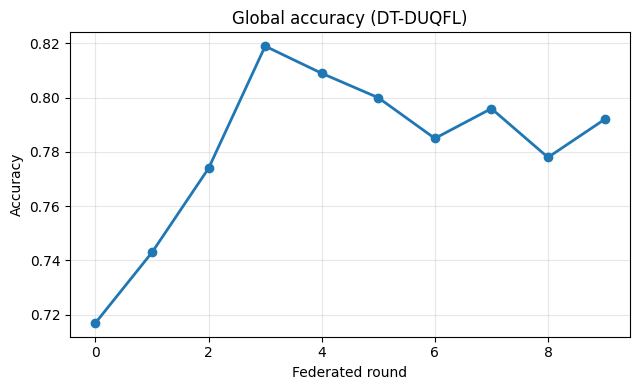

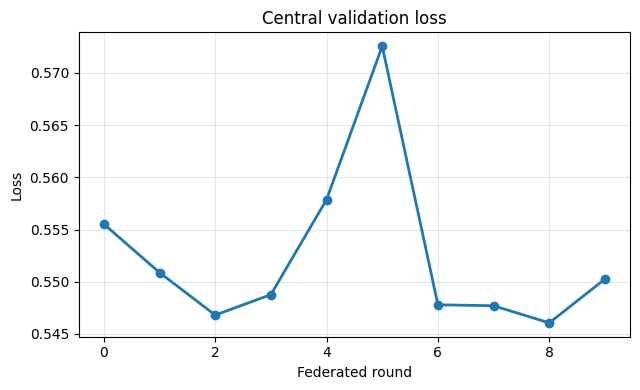

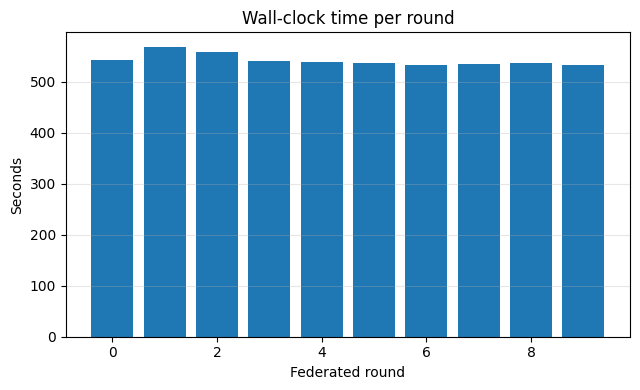

In [7]:
from training.loop import run_federated_training
from configs.base_config import use_teleportation as CFG_TEL, noise_preset, shots_used,aggregation
from training.metrics import metrics_init, metrics_log_round, metrics_finalize, compute_auc,metrics_summarize
from viz.plots import plot_accuracy_curve, plot_val_loss, plot_time_per_round, plot_fidelity_vs_delta_acc, plot_beta_hist, plot_client_fairness_last_round
# Initialize metrics store once
metrics_store = metrics_init(
    log_path=os.path.join(drive_root, "teleport_metrics_Perturb_shrink.csv")
)

#new
from ml import optimizers as mlopt
from configs.base_config import drive_root
import os

mlopt.meta_trace_enable(
    path=os.path.join(drive_root, "meta_trace.csv"),  # or None to skip CSV
    every=5                                           # print every 5 callbacks
)

###########
global_acc, clients_train, clients_test, round_times, val_losses, info_last = run_federated_training(
    clients=clients,
    num_federated_layers=num_federated_layers,
    num_deep_unfolding_iterations=num_deep_unfolding_iterations,
    initial_learning_rate=initial_learning_rate,
    initial_perturbation=initial_perturbation,
    num_features=num_features,
    best_client_csv_file=best_client_csv_file,
    global_csv_file=global_csv_file,
    local_csv_file=local_csv_file,
    validation_csv_file=validation_csv_file,
    test_sequences=test_sequences,
    test_labels=test_labels,
    X_val=X_val,
    y_val=y_val,
    use_teleportation=CFG_TEL,          # ← important
    noise_preset=noise_preset,
    shots_used=shots_used,
    metrics=metrics_store,   # <-- pass it in
    aggregation=aggregation           # <--- switch here
)

rows_np = metrics_finalize(metrics_store)   # if you need the in-memory array
#summary = metrics_summarize(metrics_store)  # prints a concise summary, returns a dict

# quick visuals
rounds = list(range(len(global_acc)))
plot_accuracy_curve(rounds, global_acc, label="Global accuracy (DT-DUQFL)")
plot_val_loss(rounds, val_losses, label="Central validation loss")
plot_time_per_round(rounds, round_times)

if info_last is not None:
    # this uses "last" round's info; in your logger you kept per-round arrays; adapt if needed
    pass
